In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import datetime as dt
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [24]:
retail.shape

(541909, 8)

In [25]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [26]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data preprocessing
* First we are gonna see how many % of missing values we have is each column

In [27]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [28]:
retail = retail.dropna()
retail.shape

(406829, 8)

# We are gonna drop CustomerID missing values, it still remain a lot of data
# Description column is only small % of missing values, so there is not a big case
* We also change data type of CustomerID from float to str

In [29]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

# Next step will be data preparation
# First we define the amount column, which is total amount of transactions by revenue contributed
* (m) as monetary

In [30]:
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


# Next will be Frequency, which is the number of transactions

In [31]:
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


# Then we merge Frequency and Amount column

In [32]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [33]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [34]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

# Then the difference between max date and transaction date

In [35]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


# Next last transaction date

In [36]:
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


# Then we convert it solo into days form, fully numerically

In [37]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


# And we name that Recency, which are the number of days since last purchase

In [38]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


# Next we deal with outliers
* First we will make outliers analysis

Text(0, 0.5, 'Attributes')

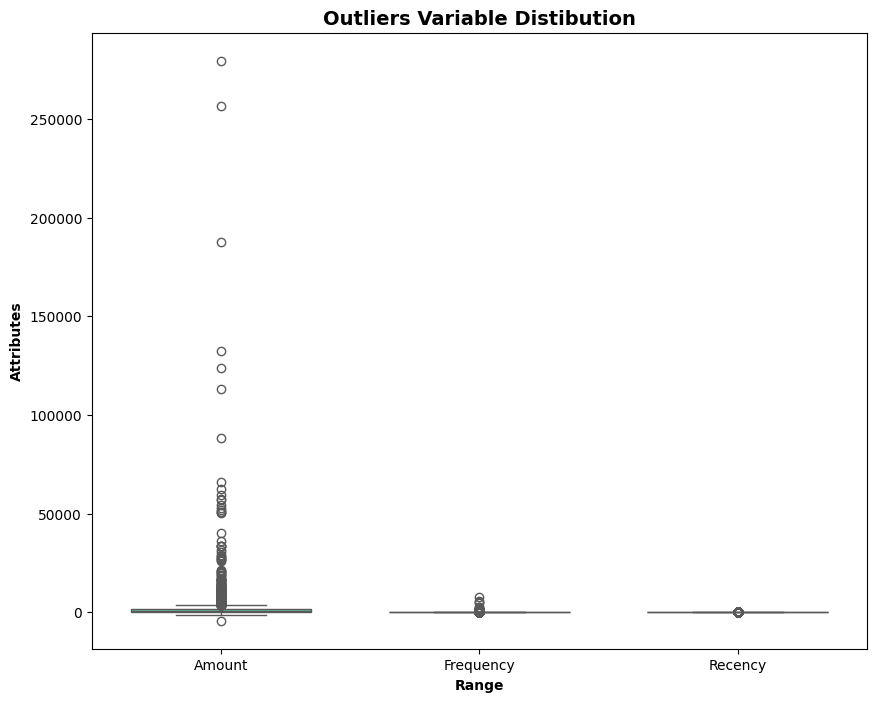

In [39]:
attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = (10,8)
sn.boxplot(data = rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title('Outliers Variable Distibution', fontsize=14, fontweight='bold')
plt.xlabel("Range", fontweight='bold')
plt.ylabel("Attributes", fontweight='bold')

# Next we are gonna remove the outliers using IQR technique - So the quantile methode
* We define upper and lower bound -  Q1 and Q3
* And next remove outliers which are beyond and below these bounds

In [40]:
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1  - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Then we check how the plot changed and we see that there are no more outliers on upper and lower bound
* The values are end around 12 500, not like previous 250 000

Text(0, 0.5, 'Attributes')

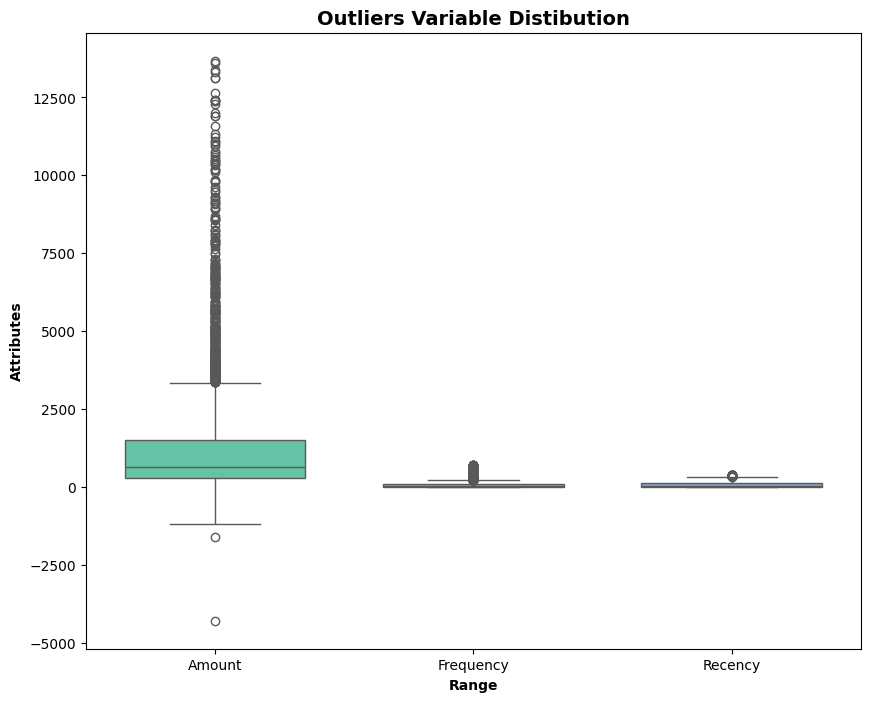

In [41]:
attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = (10,8)
sn.boxplot(data = rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title('Outliers Variable Distibution', fontsize=14, fontweight='bold')
plt.xlabel("Range", fontweight='bold')
plt.ylabel("Attributes", fontweight='bold')

# Next is the rescaling part, so i gonna scale all the values

In [42]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)

# And then we put everything together into DataFrame

In [43]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# We can see that the values has changed drastically from very high numbers to very low

In [44]:
rfm_df_scaled.describe()

,Amount,Frequency,Recency
count,4.293000e+03,4.293000e+03,4.293000e+03
mean,2.648191e-17,-4.882602e-17,5.379138e-17
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-3.166350e+00,-7.628617e-01,-9.163671e-01
25%,-5.588933e-01,-6.032747e-01,-7.480421e-01
50%,-3.631428e-01,-3.738683e-01,-4.212935e-01
75%,1.412932e-01,1.946605e-01,5.193464e-01
max,7.068221e+00,6.388632e+00,2.776882e+00


# In that part we are gonna build a model
* I start from using K-means clustering

In [45]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

# But first we need to figure out the optimal number of clusters
* We do it by using Elbow method

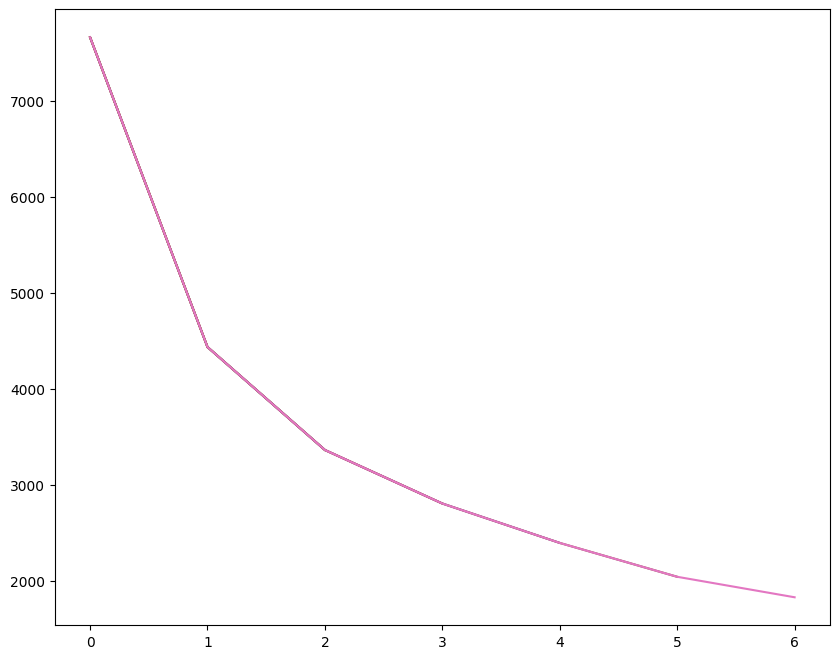

In [46]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
  kmeans.fit(rfm_df_scaled)

  ssd.append(kmeans.inertia_)

  plt.plot(ssd)

# Next we are gonna check Silhuette score
* It will tells us that if score if closer to 1 it means that the datapoint is very close to other data points
* When is closer to -1 the situation is opposite

In [47]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
  kmeans.fit(rfm_df_scaled)

  cluster_labels = kmeans.labels_

  silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
  print("For n_clusters={0}, the silhuette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhuette score is 0.5411246404292333
For n_clusters=3, the silhuette score is 0.5084896296141937
For n_clusters=4, the silhuette score is 0.47782241003860476
For n_clusters=5, the silhuette score is 0.46413788559626845
For n_clusters=6, the silhuette score is 0.41760634878151304
For n_clusters=7, the silhuette score is 0.4153122967960467
For n_clusters=8, the silhuette score is 0.4028019031535559


# Our final model have 3 clusters

In [48]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [49]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1], dtype=int32)

In [50]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


# Next i gonna check on visual plots to see in which cluster appear the most Amount, frequency and recency

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

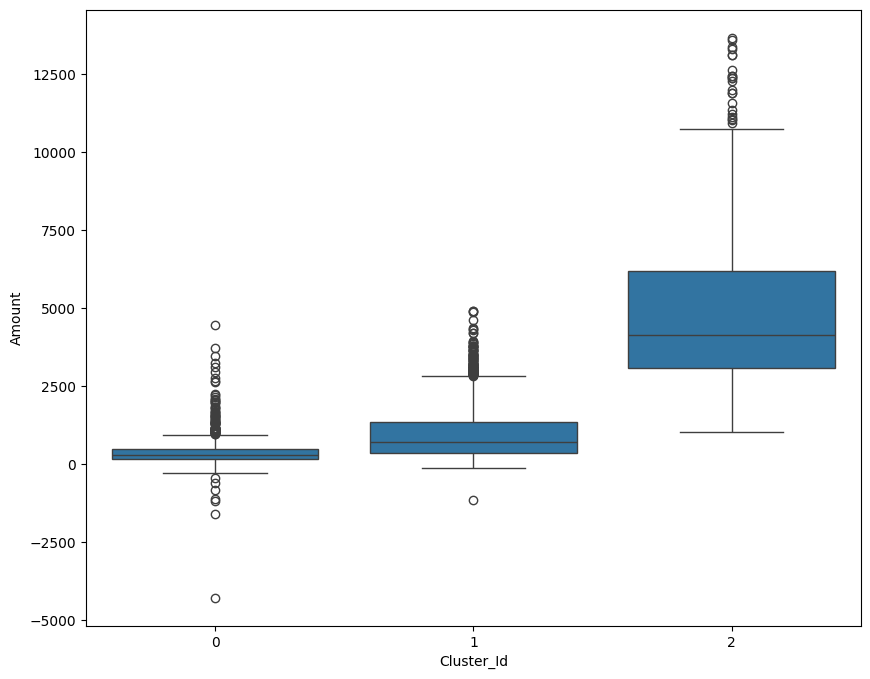

In [51]:
sn.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

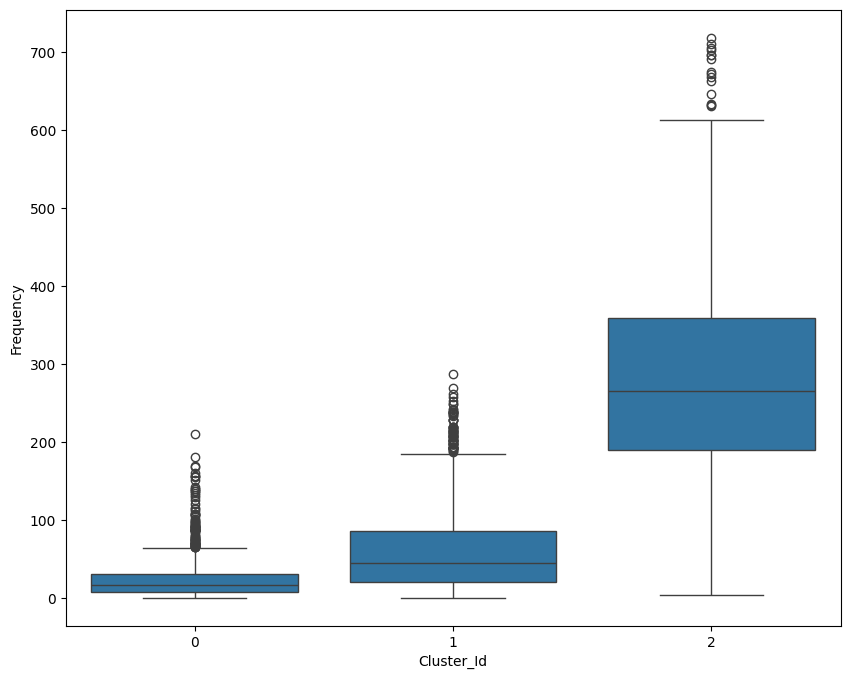

In [52]:
sn.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

# Amount is the highest it the first cluster
# Frequency also in first cluster
# Recency in terms of value, cluster number 3, but it means, that the Transactions are the oldest

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

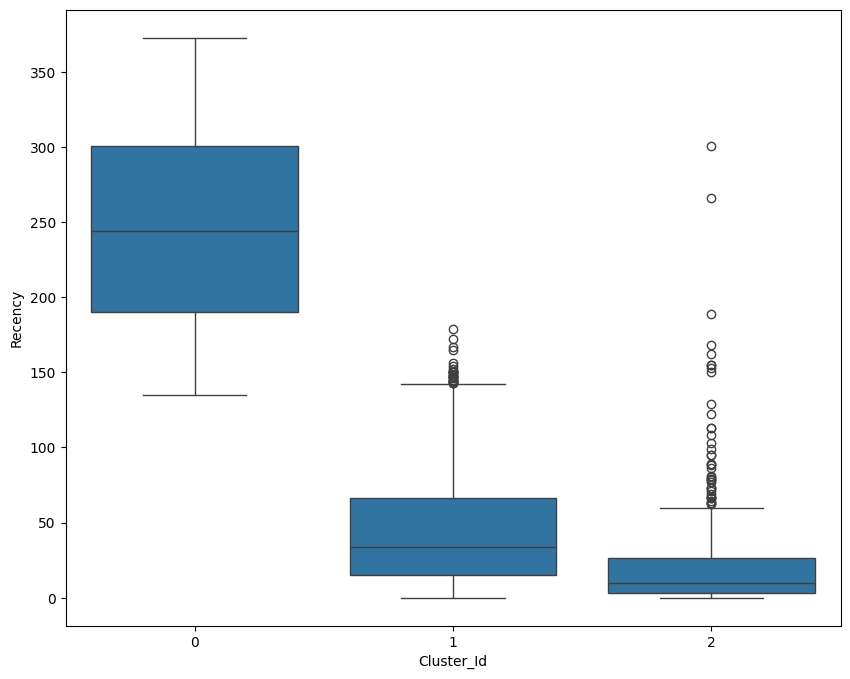

In [53]:
sn.boxplot(x='Cluster_Id', y='Recency', data=rfm)

# Next we are gonna try hierarhical clustering - average method
* It will calculate distance between 2 clusters, but taking average distance between all datapoints in clusters

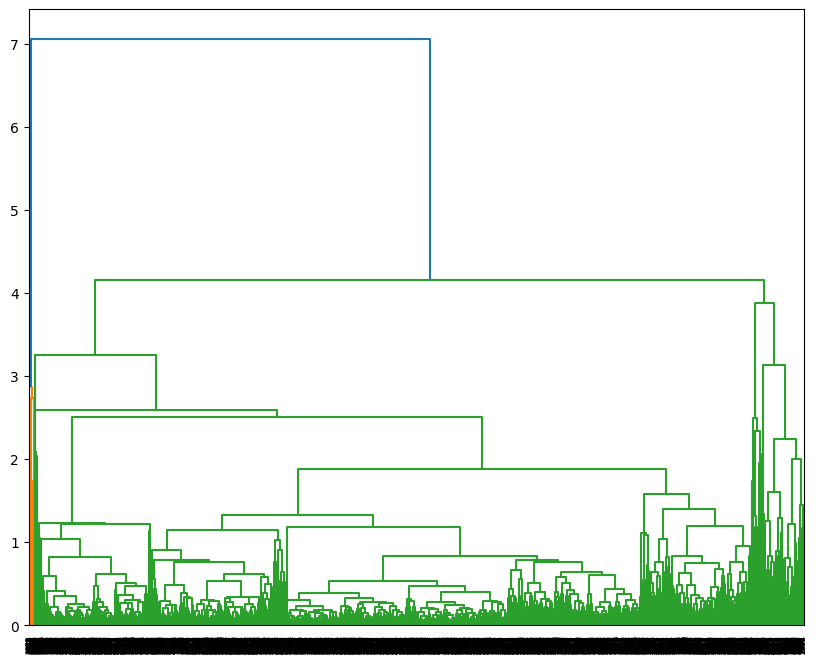

In [54]:
mergings = linkage(rfm_df_scaled, method="average", metric="euclidean")
dendrogram(mergings)
plt.show()

In [55]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

# Next we are gonna assign the cluster labels

In [56]:
rfm["Cluster_labels"] = cluster_labels
rfm.head(13)

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,2,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0
5,12352.0,1545.41,95,35,1,0
6,12353.0,89.00,4,203,0,0
7,12354.0,1079.40,58,231,0,0
8,12355.0,459.40,13,213,0,0
9,12356.0,2811.43,59,22,1,0


# And we are gonna check in which cluster occur the highest number of Amount, frequency and recency

<Axes: xlabel='Cluster_labels', ylabel='Amount'>

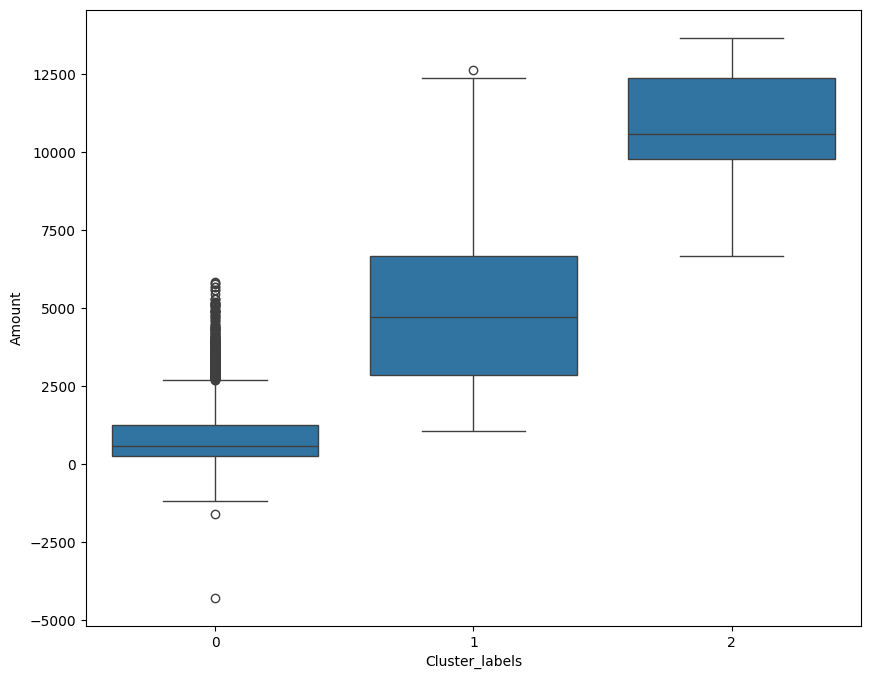

In [57]:
sn.boxplot(x="Cluster_labels", y="Amount", data=rfm)

<Axes: xlabel='Cluster_labels', ylabel='Frequency'>

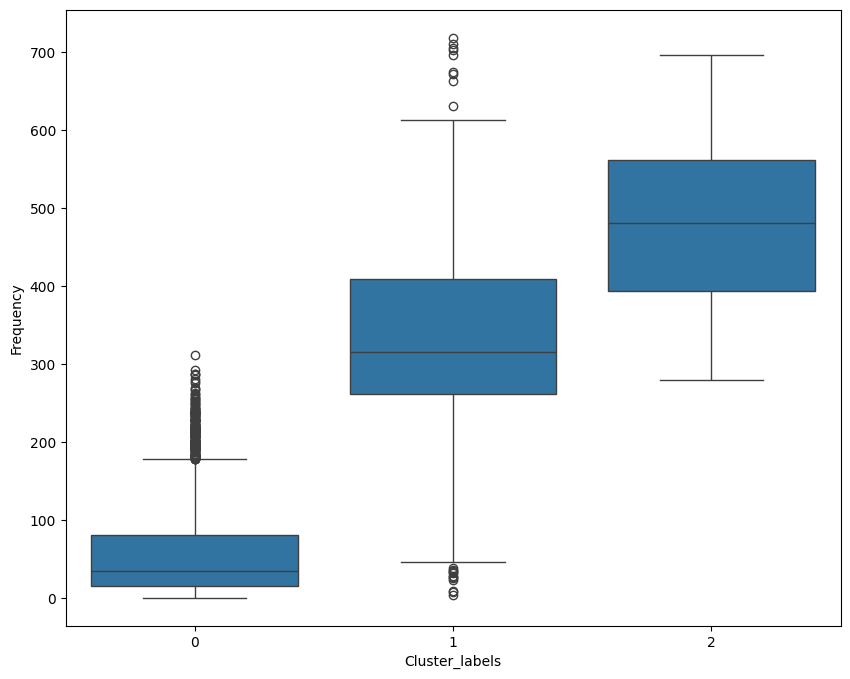

In [58]:
sn.boxplot(x="Cluster_labels", y="Frequency", data=rfm)

# As we can see KMean clustering and hierarhical clustering give us very similar conclusions

<Axes: xlabel='Cluster_labels', ylabel='Recency'>

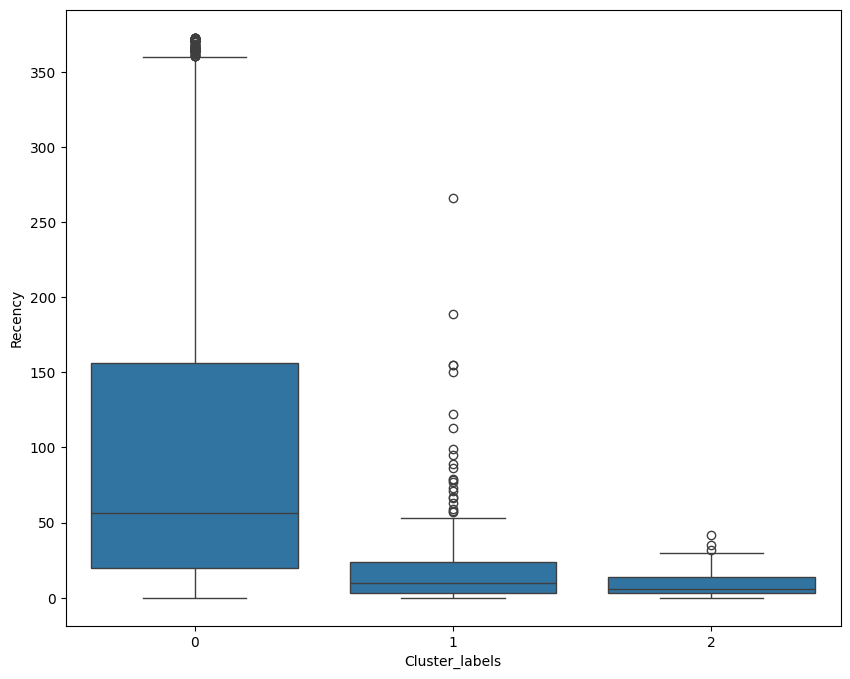

In [59]:
sn.boxplot(x="Cluster_labels", y="Recency", data=rfm)

# Final conclusions about all 3 clusters
# The Cluster's 3 customers are the best and they will be our target
# We can also consider the customers from Cluster 2 
# And we can ignore customers from Cluster 1, they are not important in terms of marketing  

# Cluster 1:
* What's the most significant to the customers in cluster 1
* Is that they are at the last place in terms of Recency, Amount and Frequency
* In this case they are definitelly outlier


# Cluster 2:
* Customers from cluster 2 are also important, but no as customers from cluster 3
* They don't have any significant characteristics, they are at the second place right after Cluster 3
* Cluster nr. 2 is placed at second  place, and still lack a lot to Cluster 3
* In difference to Kmean, the tree method gives us different values, but the order is the same
* In terms of Recency They are very similar to Cluster nr. 3

# Cluster 3:
* Customers from cluster 3 are customers with the highest Amount of buying
* And they are the most Frequent and recent buyers
* Especially In Amount they are placed far beyond the other clusters